# Лабораторная работа 1. Нейронные сети.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за всю работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_01.ipynb.

# Часть 2. Fine-tuning обученных нейросетей

В этой части задания вам предстоит поработать с настоящими монстрами: сетями с почти сотней слоёв и десятками миллионов параметров. Например, такими:

![img](https://alexisbcook.github.io/assets/inception.png)
<center>googlenet inception v3</center>

Если внимательно всмотреться в картинку, можно заметить, что синим цветом обозначены свёрточные слои, красным — pooling, зелёным — конкатенация входов и т.п.

__Чем кормить такого монстра?__

Огромные нейросети обучаются на огромных массивах данных. В компьютерном зрении таких несколько, но самый популярный из них [ImageNet](http://image-net.org/). В этой выборке более миллиона изображений.

Задача этой сети состоит в классификации каждого изображения в один из 1000 классов. Вот они:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

classes = pickle.load(open('classes.pkl','rb'))
print(classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


## Зоопарк нейросетей в keras

Если вы дошли до этого задания, значит вы уже знакомы с библиотекой Керас. Так вот, в ней кроме всего прочего, есть зоопарк предобученных нейросетей: [__`keras.applications`__](https://keras.io/applications/).

Ниже пример кода, который загружает обученную модель с картинки выше ([здесь](https://keras.io/applications/#inceptionv3) можно узнать о ней подробнее).

**Внимание!**
InceptionV3 требует много памяти для работы. Если ваш ПК начинает зависать:
* закройте всё кроме jupyter и браузера с одной вкладкой;
* если не помогло, загрузите эту тетрадку в [google colab](https://colab.research.google.com/) и работайте там;
* замените `zoo.InceptionV3` на `zoo.MobileNet`. Однако в этом случае вам придётся исправить и предобработку картинок.

Выберете оптимальный для вас вариант и начнем работу!

In [2]:
import keras, keras.layers as L
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

model.summary()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Функция ниже позволяет найти для заданного изображения топ10 классов по мнению InceptionV3.

In [4]:
from skimage.transform import resize
def predict_top10(img):
    img = resize(img, (299, 299), mode='reflect',anti_aliasing=False)
    assert img.min() >= 0.0 and img.max() <= 1.0
    plt.imshow(img)
    plt.show()

    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    probs = model.predict(img_preprocessed)[0]
    labels = probs.argsort()[-1:-10:-1]

    print('top-10 classes:')
    for l in labels:
        print('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

Проверим, как она работает на близкой к обучающей выборке картинке:

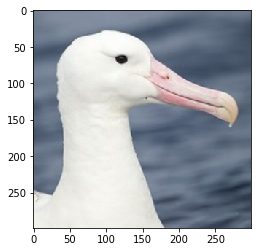

top-10 classes:
0.9282	albatross
0.0016	turnstile
0.0008	drake
0.0005	collie
0.0004	hammerhead
0.0004	Shetland sheepdog
0.0004	nipple
0.0004	cello
0.0004	goose


In [4]:
predict_top10(plt.imread('sample_images/albatross.jpg'))

А теперь попробуем ее на чем-то неожиданном!

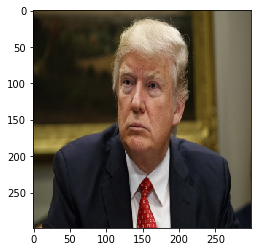

top-10 classes:
0.2418	suit
0.0915	groom
0.0294	Windsor tie
0.0111	wig
0.0095	oboe
0.0082	academic gown
0.0072	bow tie
0.0055	notebook
0.0050	mortarboard


In [11]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg
predict_top10(plt.imread('img.jpg'))

## Dogs Vs Cats

А теперь попробуем построить классификатор, который отличает изображение кошки от собаки. 

![img](https://dingo.care2.com/pictures/greenliving/1203/1202163.large.jpg)

Код ниже позволяет вам загрузить данные, необходимые для данного задания.

In [12]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

## Sklearn way

**Задание 2.1 (1 балл)** В вашем распоряжении есть предобученная сеть InceptionV3. Ваша задача — обучить классификатор из sklearn (на ваш выбор), который будет отличать котов от собак, используя __активации нейронной сети в качестве признаков__.

Для начала, прочитайте данные и сформируйте для вашего классификатора обучающую и тестовую выборки в пропорции 4:1. 

В вашем распоряжении всего 25 000 изображений различного размера, все в формате JPEG. Все картинки лежат в папке __`./train`__. Изображения кошек имеют название вида `./train/cat.*.jpg`, собак — `./train/dog.*.jpg`.

Считайте данные и для каждой картинки вычислите признаки из промежуточного слоя свёрточной сети. В качестве признаков можно выбрать какой-нибудь слой или несколько слоёв сети. Попробуйте найти комбинацию слоёв, которая работает лучше всего.

[Здесь](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer) можно почитать как посчитать активацию промежуточных слоёв.

In [54]:
# Скачиваем и отображаем MobileNet (на InceptionV3 не хватает памяти)
model = zoo.MobileNet(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [55]:
# Выделяем подмодель у MobileNet
layer_name = 'global_average_pooling2d_2'
my_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [12]:
# Считываем картинки и прогоняем их через урезанную модель, формируя X и y
import os
from skimage.io import imread
from skimage.transform import resize

path = "./train/"
count = len(os.listdir(path))
X = np.zeros((count, 1024))
y = np.zeros(count, dtype=np.int32)

i = 0
for file_name in sorted(os.listdir(path)):
    if i % 1000 == 0:
        print(i)
    image = imread(path + file_name)
    image = resize(image, (224, 224), mode='reflect', anti_aliasing=True)
    image = np.expand_dims(image, axis=0)
    X[i] = my_model.predict(image)[0, :]
    if 'dog' in file_name:
        y[i] = 0
    else:
        y[i] = 1
    i += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


Разделите данные на обучение и тест в отношении 4:1.

In [51]:
print("Размерность X =", X.shape)

Размерность X = (25000, 1024)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучите поверх этих признаков классификатор из sklearn (можно попробовать несколько и выбрать лучший). Попробуйте получить ROC-AUC __хотя бы 99%__.

In [46]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])
print("ROC-AUC =", score)

ROC-AUC = 0.9992052513890499


In [53]:
score = roc_auc_score(y_train, svc.predict_proba(X_train)[:, 1])
print("ROC-AUC (train) =", score)

ROC-AUC (train) = 0.9997793895036263


**Задание 2.2 (0.5 балла)** Опишите ваши выводы о проделанной работе.

Была взята предобученная сеть <b>MobileNet</b> со всеми слоями кроме последнего свёрточного и нескольких слоёв после неё. Через эту сеть была прогнана база <b>"Dogs vs Cats"</b>, содержащая <b>25000</b> картинок.
<br>
Сеть принимает картинки размерности <b>(224, 224, 3)</b>, поэтому для совместимости по входу сети каждую картинку необходимо было привести к этому размеру (использовалась функция skimage.transform.resize). Для каждой картинки на выходе этой сети был получен вектор признаков размера 1024.
<br>
Получившаяся матрица признаков <b>X</b> имеет размерность <b>(25000, 1024)</b>, а вектор ответов <b>y</b> принимает значения 0 или 1 (0 - собака, 1 - кошка). Все данные были разбиты на обучающую и тестовую выборки в соотношении 4:1.
<br>
Далее был использован алгоритм sklearn.svm.SVC, предсказывающий вероятность того, что данный вектор размерности 1024 характерезует класс кошка. Обученный алгоритм проверен на тестовой выборке по метрике ROC-AUC с показателем <b>99.92%</b>

## Fine-tuning

**Задание 2.3 (2 балла)** Давайте попробуем добиться ещё большего качества через дообучение (fine-tuning) модели. Новая цель — получить качество лучше, чем у классификатора из предыдущего пункта на признаках `InceptionV3`. Цель этого задания: получить значение ROC-AUC __не меньше 99.5%__.

__Шаг 1.__  Постройте сеть, в которой InceptionV3 "без головы" используется в качестве первого слоя. Поверх неё надстройте новую голову из `keras.layers` — она будет отличать котов от собак. Это можно сделать с помощью [общего интерфейса модели](https://keras.io/models/model/).

In [56]:
# Склеиваем MobileNet с полносвязным слоем
new_layer = L.Dense(1, activation='sigmoid')(my_model.output)
new_model = keras.Model(inputs=model.input, outputs=new_layer)

# Замораживаем веса всех слоёв, кроме последнего
for layer in new_model.layers[:-1]:
    layer.trainable = False

In [75]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

__Шаг 2.__ Обучите "голову" на обучающей выборке, не меняя весов изначальной сети. Частично обучать сеть в keras можно [вот так](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers).

In [57]:
# Все картинки не влезают в память - создаём генератор, считывающий их их файла
path = "./train/"

def generate_images_from_file(indecies, batch_size=64):
    file_names = sorted(os.listdir(path))
    i = 0
    while True:
        X = np.zeros((batch_size, 224, 224, 3))
        y = np.zeros(batch_size)
        for j in range(batch_size):
            file_name = file_names[indecies[i]]
            image = imread(path + file_name)
            image = resize(image, (224, 224), mode='reflect', anti_aliasing=True)
            image = np.expand_dims(image, axis=0)
            
            X[j] = image
            if 'dog' in file_name:
                y[j] = 0
            else:
                y[j] = 1
        
            i += 1
            i %= len(indecies)

        yield (X, y)

In [58]:
import os
from skimage.io import imread
from skimage.transform import resize

size = 25000
train_size = 20000
permutation = np.random.permutation(size)
train_indecies = permutation[:train_size]
val_indecies = permutation[train_size:]

In [59]:
# Обучаем модель с помощью генератора
new_model.compile(optimizer="Nadam", loss='binary_crossentropy', metrics=['acc'])
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 8), steps_per_epoch=300,
    validation_data=generate_images_from_file(val_indecies, 8), validation_steps=75, epochs=5)

Epoch 1/5
300/300 [==============================] - 149s 497ms/step - loss: 0.2516 - acc: 0.8913 - val_loss: 0.0630 - val_acc: 0.9767
Epoch 2/5
300/300 [==============================] - 132s 440ms/step - loss: 0.1703 - acc: 0.9329 - val_loss: 0.0445 - val_acc: 0.9817
Epoch 3/5
300/300 [==============================] - 134s 446ms/step - loss: 0.2052 - acc: 0.9187 - val_loss: 0.0366 - val_acc: 0.9883
Epoch 4/5
300/300 [==============================] - 132s 439ms/step - loss: 0.1629 - acc: 0.9400 - val_loss: 0.0378 - val_acc: 0.9883
Epoch 5/5
300/300 [==============================] - 132s 439ms/step - loss: 0.1423 - acc: 0.9400 - val_loss: 0.0450 - val_acc: 0.9800


Попробуем выполнить больше итераций

In [60]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 8), steps_per_epoch=300,
    validation_data=generate_images_from_file(val_indecies, 8), validation_steps=75, epochs=5)

Epoch 1/5
300/300 [==============================] - 111s 372ms/step - loss: 0.1537 - acc: 0.9392 - val_loss: 0.0469 - val_acc: 0.9850
Epoch 2/5
300/300 [==============================] - 116s 385ms/step - loss: 0.1468 - acc: 0.9479 - val_loss: 0.0373 - val_acc: 0.9850
Epoch 3/5
300/300 [==============================] - 110s 368ms/step - loss: 0.1854 - acc: 0.9321 - val_loss: 0.0320 - val_acc: 0.9933
Epoch 4/5
300/300 [==============================] - 111s 370ms/step - loss: 0.1499 - acc: 0.9479 - val_loss: 0.0347 - val_acc: 0.9900
Epoch 5/5
300/300 [==============================] - 106s 352ms/step - loss: 0.1282 - acc: 0.9483 - val_loss: 0.0355 - val_acc: 0.9850


И ещё несколько

In [61]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 8), steps_per_epoch=300,
    validation_data=generate_images_from_file(val_indecies, 8), validation_steps=75, epochs=5)

Epoch 1/5
300/300 [==============================] - 106s 354ms/step - loss: 0.1397 - acc: 0.9450 - val_loss: 0.0437 - val_acc: 0.9867
Epoch 2/5
300/300 [==============================] - 110s 368ms/step - loss: 0.1386 - acc: 0.9492 - val_loss: 0.0392 - val_acc: 0.9850
Epoch 3/5
300/300 [==============================] - 111s 370ms/step - loss: 0.1760 - acc: 0.9325 - val_loss: 0.0311 - val_acc: 0.9933
Epoch 4/5
300/300 [==============================] - 108s 361ms/step - loss: 0.1428 - acc: 0.9500 - val_loss: 0.0349 - val_acc: 0.9900
Epoch 5/5
300/300 [==============================] - 112s 375ms/step - loss: 0.1213 - acc: 0.9508 - val_loss: 0.0328 - val_acc: 0.9833


Качество перестало расти, также была замечена ошибка - передавались неправильные значения steps. Из-за этого обучение проходило не по всей выборке, а лишь по 2400 объектам. Исправим данную ошибку и выполним несколько итераций обучения

In [66]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 16), steps_per_epoch=1250,
    validation_data=generate_images_from_file(val_indecies, 16), validation_steps=312, epochs=1)

Epoch 1/1
1250/1250 [==============================] - 1003s 802ms/step - loss: 0.0895 - acc: 0.9669 - val_loss: 0.0660 - val_acc: 0.9754


In [67]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 16), steps_per_epoch=1250,
    validation_data=generate_images_from_file(val_indecies, 16), validation_steps=312, epochs=1)

Epoch 1/1
1250/1250 [==============================] - 887s 709ms/step - loss: 0.0862 - acc: 0.9686 - val_loss: 0.0705 - val_acc: 0.9742


In [68]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 16), steps_per_epoch=1250,
    validation_data=generate_images_from_file(val_indecies, 16), validation_steps=312, epochs=1)

Epoch 1/1
1250/1250 [==============================] - 975s 780ms/step - loss: 0.0839 - acc: 0.9700 - val_loss: 0.0749 - val_acc: 0.9738


In [3]:
y_pred = new_model.predict_generator(generate_images_from_file(val_indecies, 16), steps=312)

y_true = np.zeros(16 * 312, dtype=np.int32)
file_names = sorted(os.listdir(path))
for i in range(len(y_true)):
    file_name = file_names[val_indecies[i]]
    if 'dog' in file_name:
        y_true[i] = 0
    else:
        y_true[i] = 1

In [73]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_true, y_pred)
print("ROC-AUC =", score)

ROC-AUC = 0.9992722161867852


__Sanity check:__ После этого шага ваша модель должна уже быть сравнима по точности с моделями из задания 1.

Если всё получилось, самое время [сохранить модель](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model).

In [74]:
new_model.save('new_model.model')

__Шаг 3.__ "Разморозьте" несколько предыдущих слоёв модели и продолжите обучение. На этом этапе важно не переобучиться: смотрите на качество на валидации.

Если качество не улучшается, а сразу идёт вниз, попробуйте уменьшить число обучаемых слоёв или воспользуйтесь [аугментацией данных](https://keras.io/preprocessing/image/). В общем случае, всегда полезно помнить про аугментацию данных даже если и без неё всё работает — иногда она творит [чудеса](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced).

In [77]:
# Разморозим побольше слоёв
for layer in new_model.layers:
    layer.trainable = True
for layer in new_model.layers[:-14]:
    layer.trainable = False

In [78]:
# Дообучим сеть
new_model.compile(optimizer="Nadam", loss='binary_crossentropy', metrics=['acc'])
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 16), steps_per_epoch=1250,
    validation_data=generate_images_from_file(val_indecies, 16), validation_steps=312, epochs=1)

Epoch 1/1
1250/1250 [==============================] - 1008s 807ms/step - loss: 0.1172 - acc: 0.9650 - val_loss: 0.0444 - val_acc: 0.9850


In [79]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 16), steps_per_epoch=1250,
    validation_data=generate_images_from_file(val_indecies, 16), validation_steps=312, epochs=1)

Epoch 1/1
1250/1250 [==============================] - 1014s 811ms/step - loss: 0.0422 - acc: 0.9845 - val_loss: 0.0654 - val_acc: 0.9832


In [83]:
new_model.fit_generator(
    generator=generate_images_from_file(train_indecies, 16), steps_per_epoch=1250,
    validation_data=generate_images_from_file(val_indecies, 16), validation_steps=312, epochs=1)

Epoch 1/1
1250/1250 [==============================] - 1114s 891ms/step - loss: 0.0314 - acc: 0.9885 - val_loss: 0.0555 - val_acc: 0.9824


__Шаг 4.__ Вычислите финальное качество.

In [84]:
y_pred = new_model.predict_generator(generate_images_from_file(val_indecies, 16), steps=312)

In [85]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_true, y_pred)
print("ROC-AUC =", score)

ROC-AUC = 0.998969240459515


**Задание 2.4 (0.5 балла)** Напишите отчёт и вознаградите себя за старания чем-нибудь.

Была взята предобученная сеть <b>MobileNet</b> со всеми слоями кроме последнего свёрточного. К голове сети был прикреплён полносвязный слой, у которого на выходе 1 нейрон с сигмоидальной функцией активации. Все веса нейронной сети, кроме весов данного слоя были заморожены.
<br>
Исходные данные имеют размерность <b>(25000, 224, 224, 3)</b>, что много - данные не влезают в память. Для решения данной проблемы был написан генератор, который формировал batch, считывая изображения напрямую из диска. То есть в оперативной памяти из данных одновременно находился только один batch.
<br>
Все данные, как и в предыдущем подходе, были поделены на train и test в соотношении 4:1.
<br>
После нескольких итераций обучения получилось качество, сопоставимое с качеством у подхода sklearn (<b>99.927%</b> против <b>99.92%</b>)
<br>
Размораживание большего числа последних слоёв ухудшило качество по метрике ROC-AUC до <b>99.897%</b>, однаго повысило качество по метрике accuracy с <b>97.38%</b> до <b>98.24%</b>

# Всё сделали, но азарт не прошел?

В таких случаях можно пробовать следующие техники:
* Ансамбль из нескольких предобученных нейросетей. Bagging? Stacking? Boosting? Всё что пожелаете.
* Более честный эксперимент: разделяем данные на train/__dev__/test, все сравнения делаем по dev, а test используем только в самом конце.
* Аугментировать данные картинками из интернета. Уж чего, а котиков и собачек там хватает.